# Facial Emotion Recognition using CNN (FER-2013 Dataset)
This notebook implements a Convolutional Neural Network (CNN) to classify facial expressions using the FER-2013 dataset. It includes data preprocessing, class balancing, model architecture, training with callbacks, and evaluation with accuracy, loss plots, and confusion matrix.

## Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import pandas as pd
import numpy as np

## Load the FER-2013 Dataset

In [2]:
# Read the data and preview the first few rows
data = pd.read_csv("fer2013.csv",index_col = False)
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Class Distribution Visualization

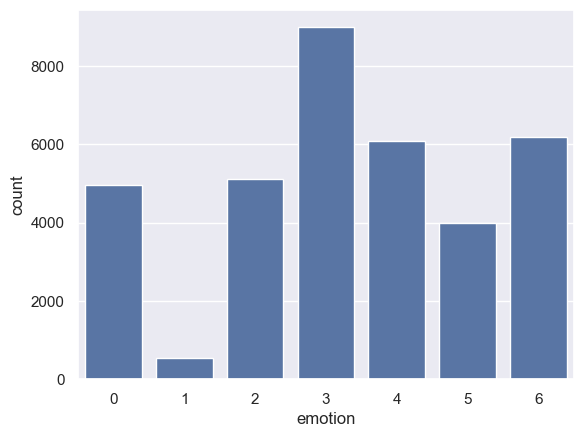

In [3]:
# Check for class imbalance in emotion labels
x_data = data['pixels']
y_data = data['emotion']
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

## Balance the Dataset using RandomOverSampler

In [4]:
# Use SMOTE/ROS to handle class imbalance by duplicating underrepresented classes
oversampler = RandomOverSampler(sampling_strategy='auto')
x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1, 1), y_data)
print(x_data.shape, y_data.shape)

(62923, 1) (62923,)


In [5]:
y_data.value_counts()

emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: count, dtype: int64

## Convert Pixels and Normalize 

In [6]:
# Convert pixel strings to arrays and normalize values to the 0-1 range
x_data = pd.Series(x_data.flatten())
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data /= 255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

## Reshape Feature and Label Arrays

In [7]:
# Reshape input to (48, 48, 1) and labels to (n, 1)
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [8]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

## Split Dataset into Training and Testing Sets

In [9]:
# Use 90% for training and 10% for testing
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=45)

## CNN Model Architecture

In [10]:
# Define a 5-layer CNN model with BatchNorm, ReLU, Dropout, and Softmax
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),

    Conv2D(64, (3,3), strides=(1,1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),

    Conv2D(128, (3,3), strides=(1,1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation='softmax')
])
model.summary()

2025-05-26 00:25:47.818356: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-26 00:25:47.820835: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-26 00:25:47.820854: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-26 00:25:47.821063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 00:25:47.821247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       409,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,407 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 690,055 (2.63 MB)

 Trainable params: 689,223 (2.63 MB)

 Non-trainable params: 832 (3.25 KB)

## Compile the Model

In [11]:
# Use Adam optimizer and categorical crossentropy loss for training
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Set Up Callbacks

In [12]:
# Early stopping and learning rate scheduler to optimize training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [early_stopping, lr_scheduler]

## One-Hot Encode Emotion Labels

In [13]:
# Convert integer labels to categorical one-hot encoding
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)

## Train the Model

In [14]:
# Fit the CNN model on training data with validation
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/30


2025-05-26 00:25:49.272233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 109s 60ms/step - accuracy: 0.1985 - loss: 4.6786 - val_accuracy: 0.4338 - val_loss: 1.7783 - learning_rate: 1.0000e-04
Epoch 2/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 109s 62ms/step - accuracy: 0.3289 - loss: 3.7216 - val_accuracy: 0.5179 - val_loss: 1.4840 - learning_rate: 1.0000e-04
Epoch 3/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 115s 65ms/step - accuracy: 0.4185 - loss: 2.4270 - val_accuracy: 0.5740 - val_loss: 1.1882 - learning_rate: 1.0000e-04
Epoch 4/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 116s 66ms/step - accuracy: 0.5020 - loss: 1.5681 - val_accuracy: 0.5994 - val_loss: 1.0545 - learning_rate: 1.0000e-04
Epoch 5/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 119s 67ms/step - accuracy: 0.5636 - loss: 1.1885 - val_accuracy: 0.6061 - val_loss: 1.0326 - learning_rate: 1.0000e-04
Epoch 6/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 118s 67ms/step - accuracy: 0.6070 - loss: 1.0304 - val_accuracy: 0.6317 - val_loss: 0.9486 - learning_rate: 1.0000e-04
Epoch 7/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 120

## Evaluate Model Performance

In [15]:
# Evaluate final model performance on the test set
model.evaluate(x_test, y_test)

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8225 - loss: 0.8108


[0.770919919013977, 0.8285396695137024]

## Plot Accuracy and Loss Curves

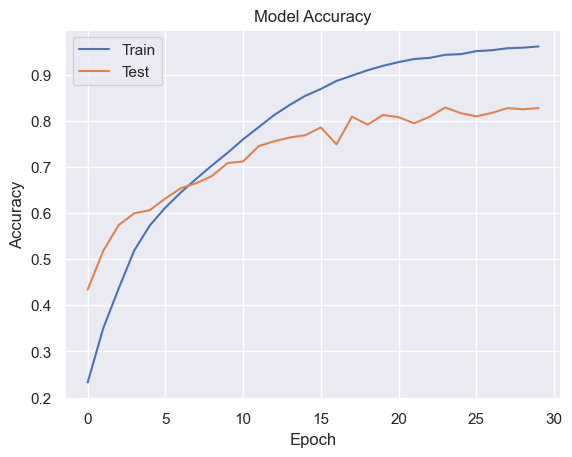

In [16]:
# Visualize training vs. validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

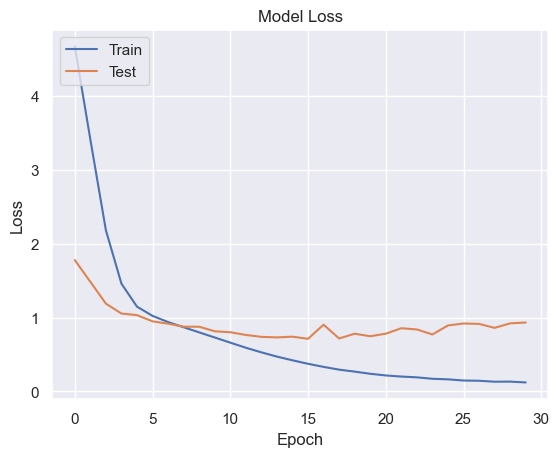

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Classification Report & Confusion Matrix

In [18]:
# Print classification report and visualize confusion matrix
y_pred = model.predict(x_test)
y_result = [np.argmax(pred) for pred in y_pred]
y_actual = [np.argmax(actual) for actual in y_test]

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


In [19]:
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       935
           1       0.98      1.00      0.99       895
           2       0.80      0.77      0.78       880
           3       0.83      0.76      0.80       906
           4       0.71      0.73      0.72       888
           5       0.93      0.93      0.93       869
           6       0.74      0.78      0.76       920

    accuracy                           0.83      6293
   macro avg       0.83      0.83      0.83      6293
weighted avg       0.83      0.83      0.83      6293



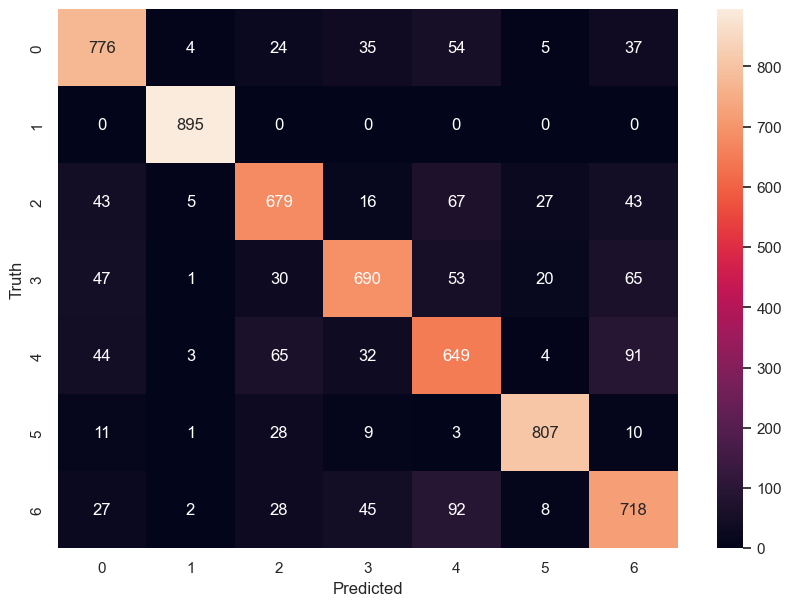

In [30]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()